In [52]:
import torch
from utils import * 
from targets import * 
from IPython.display import clear_output

In [57]:
N_D = 5000
prior_distribution = torch.distributions.MultivariateNormal(2*torch.ones(1), torch.eye(1))
D_theta = prior_distribution.sample([N_D])

target = DeformedCircles()
D_x = target.sample(D_theta)

In [58]:
from conditional_density_estimation import * 

In [65]:
model = ConditionalDIF(D_x,D_theta,50, [32,32])
model.train(100,2000, verbose = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it, loss = 3.297991 ; device: cpu]


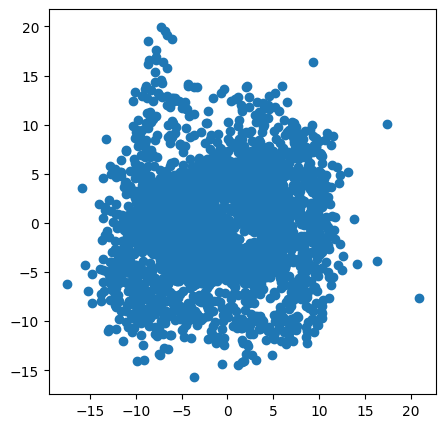

In [70]:
def plot_1d_theta_2d_x(model,range = [-3,7], number_of_plot = 50, samples_per_plot=5000):
    for theta in torch.linspace(range[0], range[1], number_of_plot):
        with torch.no_grad():
            x = model.sample(theta.unsqueeze(-1).unsqueeze(0).repeat(samples_per_plot,1))
        plot_2d_points(x, figsize = (5,5))
        clear_output(wait = True)
plot_1d_theta_2d_x(model)        

tensor([2.3748])


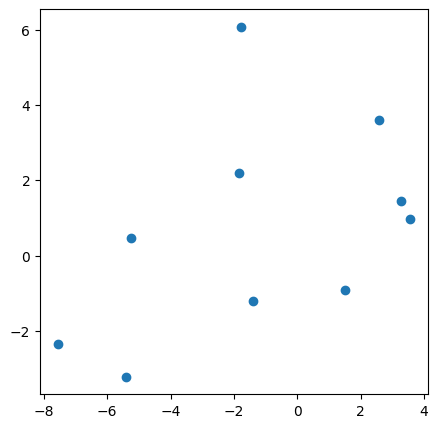

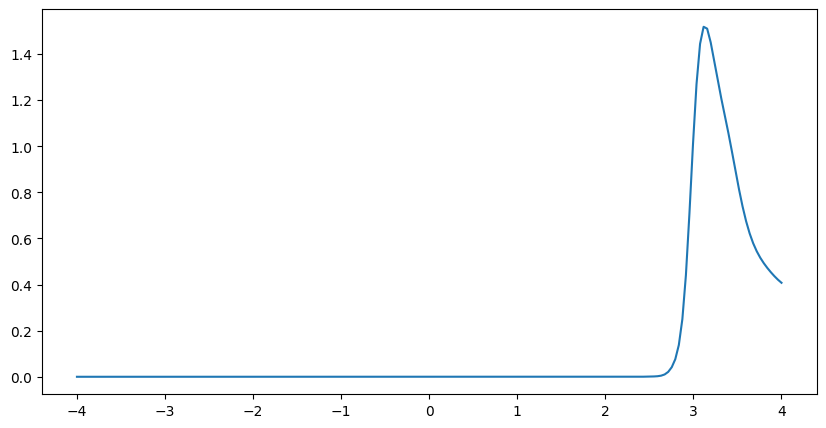

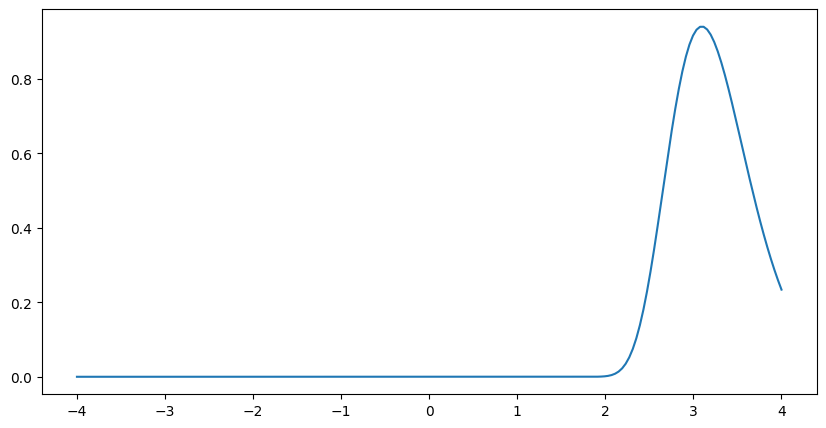

In [42]:
N_obs = 10
noise = 0.
theta0 = prior_distribution.sample()
print(theta0)
x0 = target.sample(theta0.repeat(N_obs,1), noise = noise)
plot_2d_points(x0, figsize=(5,5))
plt.show()
model_posterior = lambda samples: prior_distribution.log_prob(samples) + torch.sum(model.log_prob(x0.unsqueeze(0).repeat(samples.shape[0],1,1), samples.unsqueeze(1).repeat(1, N_obs,1)), dim =1)
plot_1d_unormalized_function(lambda samples: torch.exp(model_posterior(samples.unsqueeze(-1))),range=[-4,4],bins=200, figsize = (10,5))
true_posterior = lambda samples: prior_distribution.log_prob(samples) + torch.sum(target.log_prob(x0.unsqueeze(0).repeat(samples.shape[0],1,1), samples.unsqueeze(1).repeat(1, N_obs, 1), noise=noise), dim =1)
plot_1d_unormalized_function(lambda samples: torch.exp(true_posterior(samples.unsqueeze(-1))),range=[-4,4],bins=200,figsize = (10,5))

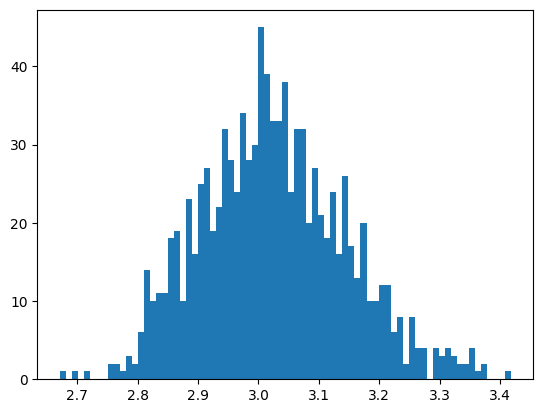

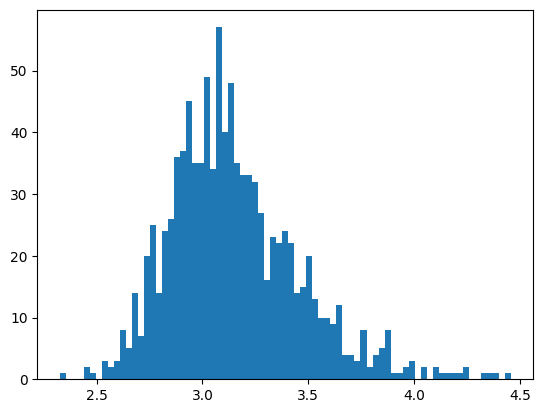

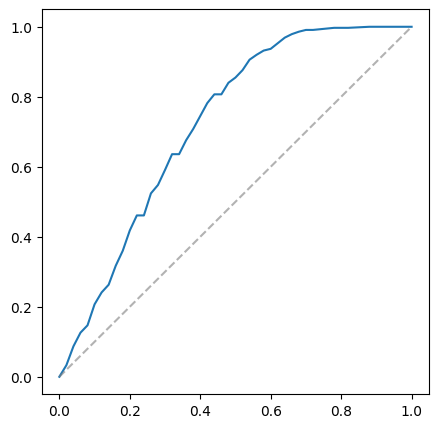

In [38]:
from markov_chain_monte_carlo import * 
model_posterior_samples = IndependentMetropolisHastings(model_posterior,1, prior_distribution, number_chains = 1000).sample(100)
plt.hist(model_posterior_samples.numpy(), bins = 75)
plt.show()
true_posterior_samples = IndependentMetropolisHastings(true_posterior,1, prior_distribution, number_chains = 1000).sample(100)
plt.hist(true_posterior_samples.numpy(), bins = 75)
plt.show()
plot_expected_coverage_1d_samples(true_posterior_samples, model_posterior_samples)